(model-building)=

# Model Building

The modeling framework of ``ELISA`` is designed to be flexible, allowing you
to construct arbitrarily complex models by combining models from ELISA or
Xspec, as well as your custom models. Links between parameters
across different model components can also be established. These models can
then be fitted to the spectral datasets.

## The Model Interface

In the context of X/$\gamma$-ray spectral fitting, a spectral model is a
photon flux model. The model may be composed by a single flux component, or
many additive flux components, and these additive components can be further
modified by multiplicative or convolution components. You can check
``ELISA``'s built-in model components from the {ref}`api`:

- [additive](#elisa.models.add)
- [multiplicative](#elisa.models.mul)
- [convolution](#elisa.models.conv)

### Create a Model
To use the spectral models in ``ELISA``, you can run the following code to import
all model classes of three types from the ``elisa.models`` module:

In [1]:
from elisa.models import *

 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996


After the import, you can create an instance of a model by calling the model
class. For example, the following code creates a [`PowerLaw`](#elisa.models.add.PowerLaw)
photon flux model:

In [2]:
m = PowerLaw()
m

No.,Component,Parameter,Value,Bound,Prior
1,PowerLaw,alpha,1.01,"(-3, 10)","Uniform(-3, 10)"
2,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"


The string representation of the model shows its name along with its model type,
the components and corresponding parameters. We can see that the parameters are
initialized with default values, bounds, and the prior distribution.
We will discuss how to configure the default values, bounds, and priors of 
these parameters in the [parameter interface](#parameter-interface) section.

Next, we can create a new model by modifying the power-law model with a photoelectric absorption component [`PhAbs`](#elisa.models.mul.PhAbs). We first create the absorption model along with the `angr` abundance table and the `vern` photoelectric cross-section. 

In [3]:
phabs = PhAbs(abund='angr', xsect='vern')
phabs

No.,Component,Parameter,Value,Bound,Prior
1,PhAbs,nH,1,"(0, 1e+06)","Uniform(0, 1e+06)"


Note that [`PhAbs`](#elisa.models.mul.PhAbs) uses `angr` abundance and `vern`
cross-section by default, and thus ``PhAbs(abund='angr', xsect='vern')`` is
equivalent to ``PhAbs()``. 

Then, we can create a new model by multiplying the power-law model with the
photoelectric absorption component:

In [4]:
m2 = phabs * PowerLaw()
m2

No.,Component,Parameter,Value,Bound,Prior
1,PhAbs,nH,1,"(0, 1e+06)","Uniform(0, 1e+06)"
2,PowerLaw,alpha,1.01,"(-3, 10)","Uniform(-3, 10)"
3,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"


Assume the model is for an extragalactic source with a redshift measurement
like $z$ = 1.5, we convolve the photon flux model with [`ZAShift`](#elisa.models.conv.ZAShift)
to account for the redshift. We first create the redshift component,

In [5]:
redshift = ZAShift(z=1.5)
redshift

No.,Component,Parameter,Value,Bound,Prior
,ZAShift,z,1.5,,


We can see that the redshift parameter is fixed to 1.5. Now we can create a new
model by convolving the previous model with the redshift component:

In [6]:
m3 = redshift(m2)
m3

No.,Component,Parameter,Value,Bound,Prior
1,PhAbs,nH,1,"(0, 1e+06)","Uniform(0, 1e+06)"
2,PowerLaw,alpha,1.01,"(-3, 10)","Uniform(-3, 10)"
3,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"
,ZAShift,z,1.5,,


The model is now a power-law model with photoelectric absorption, and further
modified by the redshift.

Note that the same model can be created with a single line code:

In [7]:
m4 = ZAShift(z=1.5)(PhAbs() * PowerLaw())
m4

No.,Component,Parameter,Value,Bound,Prior
1,PhAbs,nH,1,"(0, 1e+06)","Uniform(0, 1e+06)"
2,PowerLaw,alpha,1.01,"(-3, 10)","Uniform(-3, 10)"
3,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"
,ZAShift,z,1.5,,


Now let's have a look at the spectral shape of the model we just built,

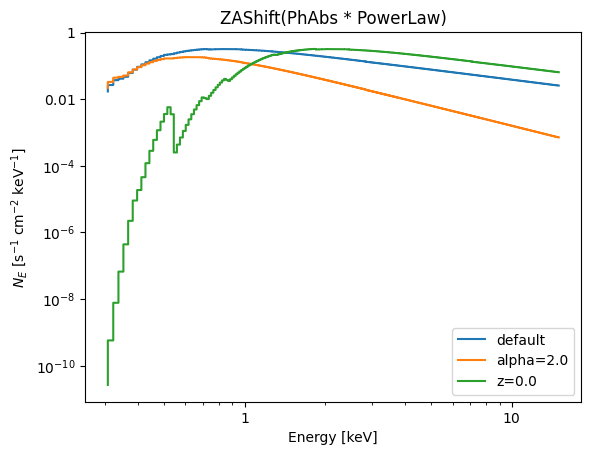

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.formatter.min_exponent'] = 3

# Compile the model and get CompiledModel instance
compiled_model = m4.compile() 

# Create a photon energy grid used to evaluate the model
photon_egrid = np.linspace(0.3, 15.0, 1000)
egrid_mid = 0.5 * (photon_egrid[:-1] + photon_egrid[1:])

# Evaluate the model with the default parameters
# photon flux N(E) [s^-1 cm^-2 keV^-1]
ne = compiled_model.ne(photon_egrid)

# You can also evaluate the model with custom
# parameters, by specifying either a full set
# or a subset of parameters to CompiledModel.ne
custom_params = {'PowerLaw.alpha': 2.0}
ne2 = compiled_model.ne(photon_egrid, params=custom_params)

ne3 = compiled_model.ne(photon_egrid, params={'ZAShift.z': 0.0})

# For Fv or vFv plot, we can use ene and eene
# ene = compiled_model.ene(photon_egrid)
# eene = compiled_model.eene(photon_egrid)

plt.step(egrid_mid, ne, label='default')
plt.step(egrid_mid, ne2, label='alpha=2.0')
plt.step(egrid_mid, ne3, label='z=0.0')
plt.legend()
plt.title(m4.name)
plt.xlabel('Energy [keV]')
plt.ylabel('$N_E$ [s$^{-1}$ cm$^{-2}$ keV$^{-1}$]')
plt.xscale('log')
plt.yscale('log')

Great! We have successfully built a model and evaluated its spectral shape.
You can build any model you want in a similar way.

```{admonition} Tip
:class: tip

The model's $F_\nu$ and $\nu F_\nu$ values can be accessed by [`CompiledModel`](#elisa.models.model.CompiledModel)'s [`ene`](#elisa.models.model.CompiledModel.ene) and
[`eene`](#elisa.models.model.CompiledModel.eene) methods.

In addition, [`CompiledModel`](#elisa.models.model.CompiledModel) provides tools
to calculate [`flux`](#elisa.models.model.CompiledModel.flux), isotropic-equivalent
[`luminosity`](#elisa.models.model.CompiledModel.lumin) and [`energy`](#elisa.models.model.CompiledModel.eiso). 
```

### Use Xspec Models

``ELISA`` can make use of ``Xspec`` [models](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/Models.html). Before using them, you need to follow the {ref}`installation` to install the [``xspex``](https://github.com/wcxve/xspex) package, which provide ``JAX`` wrappers for ``Xspec`` models.

Once [``xspex``](https://github.com/wcxve/xspex) package is installed successfully,
we can import ``Xspec`` models by

In [9]:
# Note that if you have already run the code
#     from elisa.models import *
# then the following import statement is redundant

from elisa.models import xspec

We can build a model combining models from both ``ELISA`` and ``Xspec``.
For examle,

In [10]:
m5 = TBAbs() * xspec.apec()
m5

No.,Component,Parameter,Value,Bound,Prior
1,TBAbs,nH,1,"(0, 1e+06)","Uniform(0, 1e+06)"
2,apec,kT,1,"(0.008, 64)","Uniform(0.008, 64)"
,apec,Abundanc,1,,
,apec,Redshift,0,,
3,apec,norm,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"


Reading APEC data from 3.0.9



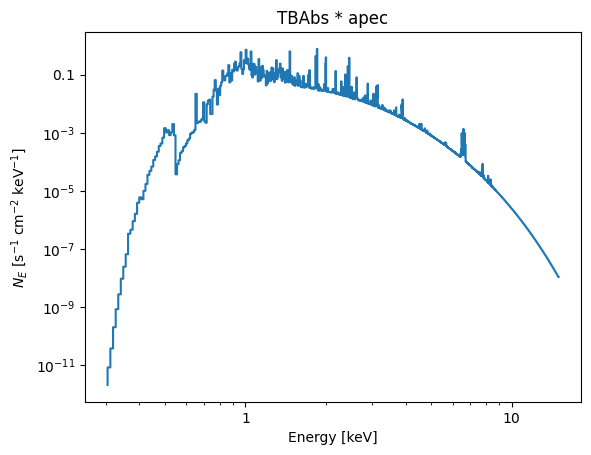

In [11]:
photon_egrid = np.linspace(0.3, 15.0, 2000)
egrid_mid = 0.5 * (photon_egrid[:-1] + photon_egrid[1:])
ne = m5.compile().ne(photon_egrid)
plt.step(egrid_mid, ne)
plt.title(m5.name)
plt.xlabel('Energy [keV]')
plt.ylabel('$N_E$ [s$^{-1}$ cm$^{-2}$ keV$^{-1}$]')
plt.xscale('log')
plt.yscale('log')

In [12]:
m6 = xspec.thcomp()(PowerLaw())
m6

No.,Component,Parameter,Value,Bound,Prior
1,PowerLaw,alpha,1.01,"(-3, 10)","Uniform(-3, 10)"
2,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"
3,thcomp,Gamma_tau,1.7,"(1.001, 10)","Uniform(1.001, 10)"
4,thcomp,kT_e,50,"(0.5, 150)","Uniform(0.5, 150)"
5,thcomp,cov_frac,0.999,"(0, 1)","Uniform(0, 1)"
,thcomp,z,0.005,,


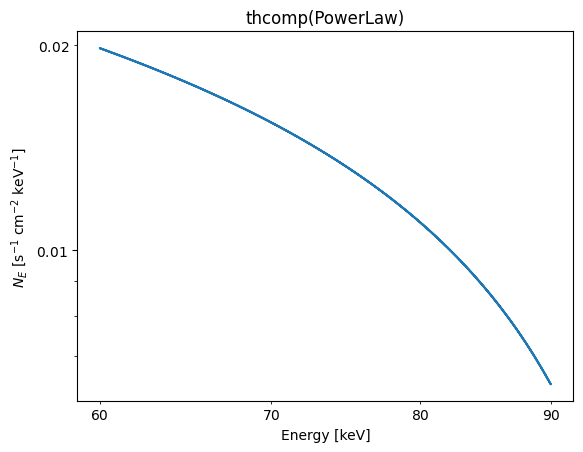

In [13]:
photon_egrid = np.linspace(60.0, 90.0, 1000)
egrid_mid = 0.5 * (photon_egrid[:-1] + photon_egrid[1:])
ne = m6.compile().ne(photon_egrid)
plt.step(egrid_mid, ne)
plt.title(m6.name)
plt.xlabel('Energy [keV]')
plt.ylabel('$N_E$ [s$^{-1}$ cm$^{-2}$ keV$^{-1}$]')
plt.xscale('log')
plt.yscale('log')

```{admonition} Warning
:class: warning

Note the [issue](https://github.com/wcxve/elisa/issues/46) that parallel
computation of certain ``Xspec`` models using JAX will fail.
Current solution to this is do the computation in sequential.
```

### Use Custom Model

You can also include custom model when building models.
See {ref}`custom-model` tutorial for details on how to make a custom model.

### Conclusion

By leveraging the model interface of ``ELISA``, you can construct arbitrarily
complex spectral models to suit your needs.

In the next section, we will discuss the parameter configuration for the model.

(parameter-interface)=
## The Parameter Interface

``ELISA`` provide an intuitive way to configure the parameters of the model
components.

As we have seen in the previous section, the model components have parameters
associated with them. These parameters have default values, bounds, and prior
distributions defined. Indeed, these parameters are instances of the
[`Parameter`](#elisa.models.parameter.Parameter) class.

### The Uniform Parameter

When creating a model without specifying the configuration of parameters,
[`UniformParameter`](#elisa.models.parameter.UniformParameter) instances are 
automatically created and assigned to model components.

For example, when we initialize a [`PowerLaw`](#elisa.models.add.PowerLaw)
simply by ``PowerLaw()``, information is read from the `PowerLaw._config`
attribute and passed to the [`UniformParameter`](#elisa.models.parameter.UniformParameter)
to create the parameter objects for the power-law model. The information includes
the default values, bounds, and flags to indicate whether the parameters are
parameterized in logarithmic space and whether to be fixed. This is also the
case for other model components.

In [14]:
for i in PowerLaw._config:
    print(i, end='\n\n')

ParamConfig(name='alpha', latex='\\alpha', unit='', default=1.01, min=-3.0, max=10.0, log=False, fixed=False)

ParamConfig(name='K', latex='K', unit='cm^-2 s^-1 keV^-1', default=1.0, min=1e-10, max=10000000000.0, log=False, fixed=False)



In [15]:
PowerLaw()

No.,Component,Parameter,Value,Bound,Prior
1,PowerLaw,alpha,1.01,"(-3, 10)","Uniform(-3, 10)"
2,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"


We can see that the configuration of parameters matches the information printed
above.

Usually, it is fine to use the default configuration. However, you can customize
the parameters for your need. For example, you can create [`UniformParameter`](#elisa.models.parameter.Parameter) instances with custom default values and bounds, and then
passed to the model constructor:

In [16]:
from elisa import UniformParameter

alpha = UniformParameter(
    name='alpha',
    default=2.0,
    min=0.0,
    max=5.0,
    log=False,
    fixed=False
)

K = UniformParameter(
    name='K',
    default=10,
    min=1e-5,
    max=1e5,
    log=True,
    fixed=False
)

PowerLaw(alpha=alpha, K=K)

No.,Component,Parameter,Value,Bound,Prior
1,PowerLaw,alpha,2,"(0, 5)","Uniform(0, 5)"
2,PowerLaw,K,10,"(1e-05, 1e+05)","LogUniform(1e-05, 1e+05)"


``ELISA`` also provides several convenient ways to set up the [`UniformParameter`](#elisa.models.parameter.UniformParameter) for model components, without the need to create the [`UniformParameter`](#elisa.models.parameter.UniformParameter) instances explicitly: 

Passing size one float sequence to the model constructor will create a [`UniformParameter`](#elisa.models.parameter.UniformParameter) with the float as the default value,

In [17]:
PowerLaw(alpha=[1.7])

No.,Component,Parameter,Value,Bound,Prior
1,PowerLaw,alpha,1.7,"(-3, 10)","Uniform(-3, 10)"
2,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"


Passing three-sequence will create a [`UniformParameter`](#elisa.models.parameter.UniformParameter) with the first element as the default value, the second and third elements as the minimum and maximum values,

In [18]:
Blackbody(kT=(10, 2, 30), K=[1.1, 1e-5, 1e4])

No.,Component,Parameter,Value,Bound,Prior
1,Blackbody,kT,10,"(2, 30)","Uniform(2, 30)"
2,Blackbody,K,1.1,"(1e-05, 1e+04)","Uniform(1e-05, 1e+04)"


Passing a four-sequence will create a [`UniformParameter`](#elisa.models.parameter.UniformParameter) with the first three elements as the default, minimum and maximum values, and the fourth element as the flag to indicate whether the parameter is logarithmically parameterized,

In [19]:
TBAbs(nH=[3.0, 0.01, 10.0, True])

No.,Component,Parameter,Value,Bound,Prior
1,TBAbs,nH,3,"(0.01, 10)","LogUniform(0.01, 10)"


And finally, passing a float will create a UniformParameter with the float as the default value, and the parameter is fixed to this value,

In [20]:
ZAShift(z=4.2)

No.,Component,Parameter,Value,Bound,Prior
,ZAShift,z,4.2,,


### Other Parameters

In addition to the [`UniformParameter`](#elisa.models.parameter.UniformParameter), ``ELISA`` provides three other types of parameters.

#### DistParameter

You can create a [`DistParameter`](#elisa.models.parameter.DistParameter) instance
by passing a ``NumPyro``'s [probability distribution](https://num.pyro.ai/en/stable/distributions.html)
instance. This is useful when you want to use non-uniform priors for parameters
in Bayesian analysis. For example, we can create a multiplicative [``Constant``](#elisa.models.mul.Constant) component with a Gaussian prior in $\mathbb{R^+}$.

In [21]:
import numpyro.distributions as dist
from elisa import DistParameter

f = DistParameter(
    name='f',
    dist=dist.TruncatedNormal(
        loc=1.0,
        scale=0.2,
        low=0.0,
    ),
    default=1.0,
)
Constant(f=f)

No.,Component,Parameter,Value,Bound,Prior
1,Constant,f,1,GreaterThan(lower_bound=0.0),LeftTruncatedDistribution(low=0)


#### ConstantInterval

When assigning [`ConstantInterval`](#elisa.models.parameter.ConstantInterval)
parameters to a model component, the model will be evaluated according to the
following formula:

$$\frac{1}{\prod_i (b_i - a_i)} \int f(E, \vec{\theta}(\vec{p}, \vec{q})) \, \mathrm{d} \vec{p}$$

where $f$ is the model function, $\vec{\theta}$ is the parameter vector of the
model, $\vec{p}$ is the [`ConstantInterval`](#elisa.models.parameter.ConstantInterval)
parameters, $\vec{q}$ is the other parameters, and $a_i$ and $b_i$ are
the intervals given by $\vec{p}$.

In [22]:
from elisa import ConstantInterval

alpha = ConstantInterval(
    name='alpha',
    interval=[1.0, 3.0],
)
m7 = PowerLaw(alpha=alpha)
m7

No.,Component,Parameter,Value,Bound,Prior
,PowerLaw,alpha,"[1, 3]",,
1,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"


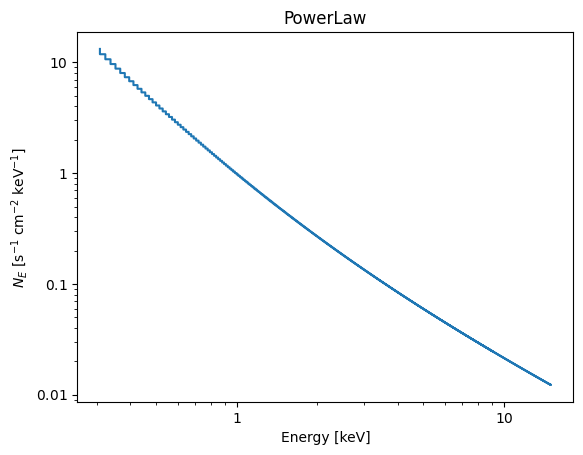

In [23]:
photon_egrid = np.linspace(0.3, 15.0, 1000)
egrid_mid = 0.5 * (photon_egrid[:-1] + photon_egrid[1:])
ne = m7.compile().ne(photon_egrid)
plt.step(egrid_mid, ne)
plt.title(m7.name)
plt.xlabel('Energy [keV]')
plt.ylabel('$N_E$ [s$^{-1}$ cm$^{-2}$ keV$^{-1}$]')
plt.xscale('log')
plt.yscale('log')

#### CompositeParameter

[`CompositeParameter`](#elisa.models.parameter.CompositeParameter) combines
multiple parameters into a single parameter. The value of the composite
parameter is calculated by a user-defined function that takes the values of
the constituent parameters as input. Note that the function must be ``JAX``
compatible.

It is the key for linking parameters across different model components. For
example, we can create a double [`Blackbody`](#elisa.models.add.Blackbody)
model, forcing the temperature of one component to be smaller than that of the
other,

In [24]:
import jax.numpy as jnp
from elisa import CompositeParameter

# Define the temperature parameter of the first blackbody
kT1 = UniformParameter(
    name='kT',
    default=10.0,
    min=0.1,
    max=150.0,
)

# Define a factor lies in [0.01, 1.0]
f = UniformParameter(
    name='f',
    default=0.2,
    min=0.01,
    max=1.0,
)

# Use CompositeParameter to define the temperature
# parameter of the second Blackbody, so that it is
# always smaller than kT1 
kT2 = CompositeParameter(
    params=[f, kT1],
    op=lambda x, y: jnp.multiply(x, y),  # x * y also works
    op_name='{} * {}',
)
m8 = Blackbody(kT=kT1) + Blackbody(kT=kT2)
m8

No.,Component,Parameter,Value,Bound,Prior
1,Blackbody,kT,10,"(0.1, 150)","Uniform(0.1, 150)"
2,Blackbody,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"
*,Blackbody_2,kT,f * Blackbody.kT,,
3,Blackbody_2,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"
4,,f,0.2,"(0.01, 1)","Uniform(0.01, 1)"


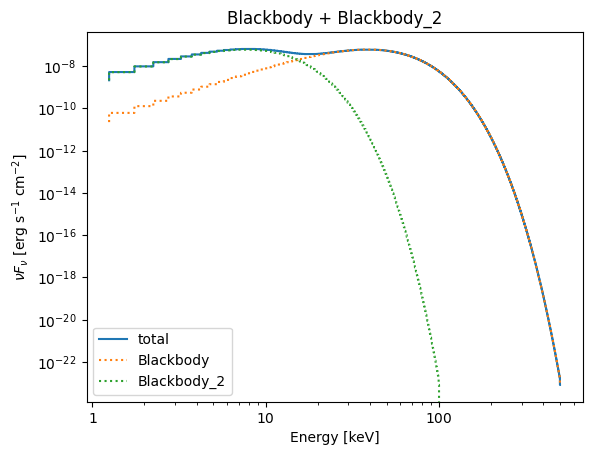

In [25]:
photon_egrid = np.linspace(1, 500.0, 1000)
egrid_mid = 0.5 * (photon_egrid[:-1] + photon_egrid[1:])
compiled_model = m8.compile()
vFv = compiled_model.eene(photon_egrid)
bb1 = compiled_model.eene(photon_egrid, params={'Blackbody_2.K': 0.0})
bb2 = compiled_model.eene(photon_egrid, params={'Blackbody.K': 0.0})
plt.step(egrid_mid, vFv, label='total')
plt.step(egrid_mid, bb1, ls=':', label='Blackbody')
plt.step(egrid_mid, bb2, ls=':', label='Blackbody_2')
plt.legend()
plt.title(m8.name)
plt.xlabel('Energy [keV]')
plt.ylabel(r'$\nu F_\nu$ [erg s$^{-1}$ cm$^{-2}$]')
plt.xscale('log')
plt.yscale('log')

We can create a series of power-law models, whose photon indices are evolving
from hard to soft,

In [26]:
# Create 10 time bins
n = 5
time_grid = np.linspace(0.0, 5.0, n + 1) 

# The initial photon index
a0 = UniformParameter(
    name='a0',
    default=0.5,
    min=0.1,
    max=1.0,
)

# The decreasing rate of photon index 
rate = UniformParameter(
    name='r',
    default=1.0,
    min=0.5,
    max=2.0,
)

models = []
for i in range(n):
    t = ConstantInterval('t', time_grid[i:i+2])
    alpha = a0 + t * rate
    models.append(PowerLaw(alpha=alpha))
models[0]

No.,Component,Parameter,Value,Bound,Prior
,PowerLaw,alpha,a0 + t * r,,
1,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"
2,,a0,0.5,"(0.1, 1)","Uniform(0.1, 1)"
,,t,"[0, 1]",,
3,,r,1,"(0.5, 2)","Uniform(0.5, 2)"


In [27]:
models[1]

No.,Component,Parameter,Value,Bound,Prior
,PowerLaw,alpha,a0 + t * r,,
1,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"
2,,a0,0.5,"(0.1, 1)","Uniform(0.1, 1)"
,,t,"[1, 2]",,
3,,r,1,"(0.5, 2)","Uniform(0.5, 2)"


Note the a0 and r parameters are shared among models.

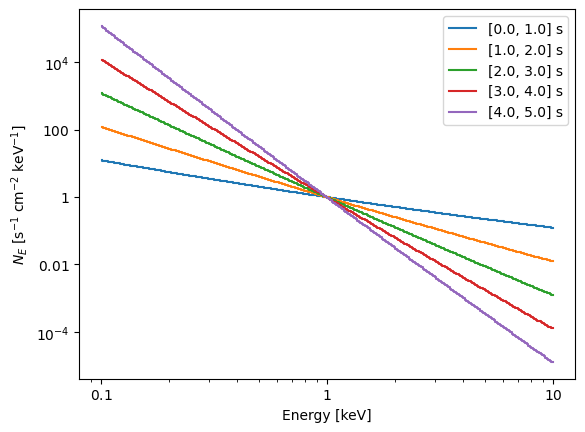

In [28]:
# Plot default decreasing rate 
photon_egrid = np.geomspace(0.1, 10.0, 300)
egrid_mid = 0.5 * (photon_egrid[:-1] + photon_egrid[1:])
for i in range(n):
    ne = models[i].compile().ne(photon_egrid)
    label = f'[{time_grid[i]}, {time_grid[i+1]}] s'
    plt.step(egrid_mid, ne, label=label)
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel('$N_E$ [s$^{-1}$ cm$^{-2}$ keV$^{-1}$]')
plt.xscale('log')
plt.yscale('log')

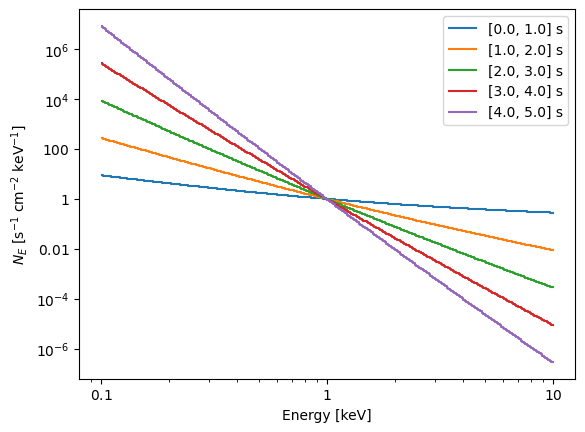

In [29]:
# Plot a0=0, r=0.2
params = {'a0': 0, 'r': 1.5}
photon_egrid = np.geomspace(0.1, 10.0, 300)
egrid_mid = 0.5 * (photon_egrid[:-1] + photon_egrid[1:])
for i in range(n):
    ne = models[i].compile().ne(photon_egrid, params=params)
    label = f'[{time_grid[i]}, {time_grid[i+1]}] s'
    plt.step(egrid_mid, ne, label=label)
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel('$N_E$ [s$^{-1}$ cm$^{-2}$ keV$^{-1}$]')
plt.xscale('log')
plt.yscale('log')

When generating the `alpha` parameters for power-law model for each time slice,
we set ``alpha = a0 + t * rate``, rather than using the [`CompositeParameter`](#elisa.models.parameter.CompositeParameter). This is because ``ELISA`` provides a set of arithmetic
operators to create [`CompositeParameter`](#elisa.models.parameter.CompositeParameter)
in a more straightforward way.
We can use these operators on two parameters (including composite ones):

- `+`: sum
- `-`: subtraction
- `*`: multiplication
- `/`: division
- `**`: power

For example,

In [30]:
x = UniformParameter('x', 5, 1, 10)
y = UniformParameter('y', -2, -5, 10)
z = x ** y
print(type(z).__name__, z)

CompositeParameter x^y


### Manipulating Parameters of Components

We can manipulate the parameters of the components after the model is created.

In [31]:
m9 = PowerLaw()

# We first get the powerlaw component,
# then modify K of the component.
# Note that K is a UniformParameter by default,
# with the default, min, max, log, and fixed attributes.

K = m9.PowerLaw.K
print(
    'K',
    type(K).__name__,
    K.default,
    K.min,
    K.max,
    K.log,
    K.fixed,
    sep=', '
)
m9

K, UniformParameter, 1.0, 1e-10, 10000000000.0, False, False


No.,Component,Parameter,Value,Bound,Prior
1,PowerLaw,alpha,1.01,"(-3, 10)","Uniform(-3, 10)"
2,PowerLaw,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"


In [32]:
m9.PowerLaw.K.default = 1.5
m9['PowerLaw'].K.min = 0.1
m9.PowerLaw['K'].max = 5.0
m9['PowerLaw']['K'].log = True
m9

No.,Component,Parameter,Value,Bound,Prior
1,PowerLaw,alpha,1.01,"(-3, 10)","Uniform(-3, 10)"
2,PowerLaw,K,1.5,"(0.1, 5)","LogUniform(0.1, 5)"


In [33]:
# Set K to DistParameter with LogNormal distribution
m9.PowerLaw.K = DistParameter(
    name='K',
    dist=dist.LogNormal(10, 1),
    default=10,
)
m9

No.,Component,Parameter,Value,Bound,Prior
1,PowerLaw,alpha,1.01,"(-3, 10)","Uniform(-3, 10)"
2,PowerLaw,K,10,Positive(lower_bound=0.0),"LogNormal(loc=10, scale=1)"


A more convenient method to create a model with two blackbodies, as shown in the example above, is as follows:

In [34]:
f = UniformParameter('f', 0.5, 0.01, 1.0)
m10 = Blackbody() + Blackbody()
m10.Blackbody_2.kT = f * m10.Blackbody.kT
m10

No.,Component,Parameter,Value,Bound,Prior
1,Blackbody,kT,3,"(0.0001, 200)","Uniform(0.0001, 200)"
2,Blackbody,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"
*,Blackbody_2,kT,f * Blackbody.kT,,
3,Blackbody_2,K,1,"(1e-10, 1e+10)","Uniform(1e-10, 1e+10)"
4,,f,0.5,"(0.01, 1)","Uniform(0.01, 1)"


### Conclusion

The parameter interface of ``ELISA`` provides versatile approaches to configuring
the parameters of model components. You can use parameters with default
configuration, or create parameters with custom values, bounds, and priors.
Additionally, linking parameters across various model components is supported.